# Compute Statuscodes
1. check where each train is at the moment
2. collect trip ids of trains that are somewhere on the map right now
3. check between which stations each trip is
4. find the stretch each trip is on
5. calculate the position of each train on their respective stretch
6. lookup the stretch segment each stretch is on
7. put the statuscode together and output

In [269]:
import datetime
from dotenv import load_dotenv
from os import getenv
import pandas as pd
from operator import itemgetter

load_dotenv()

STOPTIMES_PATH = 'stoptimes.csv'
STRETCHES_PATH = './static/stretches.csv'
STRETCH_SEGMENTS_PATH = './static/stretch_segments.csv'
STATIONS_PATH = './static/stations.csv'

# chatgpt generiert lol
import datetime
def dateToDBDate(date: datetime.date) -> str:
    """
    Wandelt ein datetime.date Objekt in einen DB-Date-String "YYMMDD" um.
    """
    return date.strftime("%y%m%d")


def datetimeToDBDatetime(dt: datetime.datetime) -> str:
    """
    Wandelt ein datetime.datetime Objekt in einen DB-Datetime-String "YYMMDDHHMM" um.
    """
    return dt.strftime("%y%m%d%H%M")


def DBDatetimeToDatetime(dbDate: str) -> datetime.datetime:
    """
    Wandelt einen DB-Datetime-String "YYMMDDHHMM" in ein datetime.datetime Objekt um.
    """
    return datetime.datetime.strptime(dbDate, "%y%m%d%H%M")


def DBDateToDate(dbDate: str) -> datetime.date:
    """
    Wandelt einen DB-Date-String "YYMMDD" in ein datetime.date Objekt um.
    """
    return datetime.datetime.strptime(dbDate, "%y%m%d").date()

def datetimeToDBDateAndHourTuple(dt: datetime.datetime):
    date = dt.strftime("%y%m%d")
    hour = dt.strftime("%H")
    return (date, hour)
    
       
print(dateToDBDate(datetime.date(2025, 8, 10)))
print(datetimeToDBDatetime(datetime.datetime(2025, 8, 10, 12, 22)))
print(DBDateToDate("250810"))
print(DBDatetimeToDatetime("2508101222"))
print(datetimeToDBDateAndHourTuple(datetime.datetime(2025, 8, 10, 12, 22)))

250810
2508101222
2025-08-10
2025-08-10 12:22:00
('250810', '12')


In [270]:
df_stoptimes = pd.read_csv(STOPTIMES_PATH, dtype=str).dropna(how='all')


# OPTIONALLY FETCH CHANGES HERE



# remove request_timestamp and request_uic because they were only needed in the df_stoptimes.csv for the preprocessing
# to identify outdated and cached data and during change application to match the changes to the stoptime entries.
# But they are not needed anymore and as the stoptimes.csv is only read but not overwritten in this script, they can go
df_stoptimes = df_stoptimes.drop(labels=[ 'request_timestamp'], axis=1)


In [271]:
# convert arrival and departure to datetimes
df_stoptimes['arrival'] = df_stoptimes['arrival_dbdatetime'].map(DBDatetimeToDatetime)
df_stoptimes['departure'] = df_stoptimes['departure_dbdatetime'].map(DBDatetimeToDatetime)

# remove old date columns
df_stoptimes = df_stoptimes.drop(['arrival_dbdatetime', 'departure_dbdatetime'], axis=1)

In [272]:
# find active trip ids

current_datetime = datetime.datetime.now()
    
# train is departed, when the departure time was before now
df_stoptimes['has_departed_station'] = df_stoptimes['departure'] < current_datetime

# find tripids with one stop time and remove them, as for identifying a position on a stretch at least two stops are needed.
tripids_with_one_stoptime_mask = df_stoptimes.groupby("trip_id")["trip_id"].transform("count") == 1
df_stoptimes = df_stoptimes.drop(df_stoptimes[tripids_with_one_stoptime_mask].index)

# find tripids where all stops have been departed and remove them, as that means the trip has ended
tripids_ended_mask = df_stoptimes.groupby("trip_id")["has_departed_station"].transform("all")
df_stoptimes = df_stoptimes.drop(df_stoptimes[tripids_ended_mask].index)

# find tripids where not any stops have been departed and remove them, as that means the trip has not started yet
tripids_not_started_mask = ~df_stoptimes.groupby("trip_id")["has_departed_station"].transform("any")
df_stoptimes = df_stoptimes.drop(df_stoptimes[tripids_not_started_mask].index)

# only the active trips remain

no_active_trips = df_stoptimes['trip_id'].unique().shape[0]
print(f"found {no_active_trips} active trips")

found 12 active trips


In [273]:
# find the two stations, between which each train is traveling (standing at a station until departure counts to being between the two stations. 
# The stopping time animation is handled by calculating where the train is between the two stations and 
# standing at the second station simply gets mapped to having travelled 100% of the time)
# therefore the previous station is the last of the departed stations and the next station is the first of the undeparted stations

previous_stations = df_stoptimes[df_stoptimes['has_departed_station'] == True].groupby(by=['trip_id'], as_index=False).last()
next_stations = df_stoptimes[df_stoptimes['has_departed_station'] == False].groupby(by=['trip_id'], as_index=False).first()

# has_departed_station now not needed anymore
previous_stations = previous_stations.drop(labels=['has_departed_station'], axis=1)
next_stations = next_stations.drop(labels=['has_departed_station'], axis=1)

df_trip_statuses = pd.merge(how='inner', left=previous_stations, right=next_stations, on=['trip_id', 'category', 'number'], suffixes=("_previous", "_next"))

In [274]:
# load graph representation of network
# station -> nodes
# stretches -> edges

import networkx as nx

stretches = pd.read_csv(STRETCHES_PATH, dtype=str).dropna(how='all')
stations = pd.read_csv(STATIONS_PATH, dtype=str).dropna(how='all')

G = nx.Graph()

# add nodes
station_list = list(stations.itertuples(index=False, name=None)) # [(station_name, station_uic)]
nodes = [(station[1], {'station_name': station[0]}) for station in station_list]
G.add_nodes_from(nodes)

# add edges
# attraction force is used to draw the graph by defining the attraction force between the two nodes and is the inverted travel time
edge_list = list(stretches[['station_uic_from', 'station_uic_to', 'station_name_from','station_name_to','travel_cost','super_name']].itertuples(index=False, name=None)) # [(station_name_from, station_uic_from, station_name_to, station_uic_from, travel_cost, super_name)]
edges = [(edge[0], edge[1], {'station_name_from': edge[2], 'station_name_to': edge[3], 'travel_cost': int(edge[4]), 'super_name': edge[5], 'attraction_force': 1 / int(edge[4])}) for edge in edge_list]
G.add_edges_from(edges)




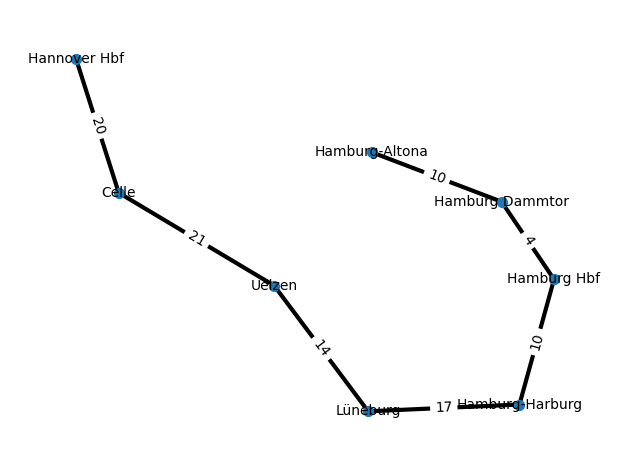

In [275]:
# draw graph for development
if True:
    import matplotlib.pyplot as plt

    pos = nx.spring_layout(G, seed=7, weight='attraction_force')  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=50)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=3)

    # node labels
    labels = {n: d["station_name"] for n, d in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", labels=labels)
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "travel_cost")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [276]:
# calculate where the train is
import numpy as np

# calculate path between the stations, the trip is currently travelling
def compute_position_on_graph(row):
    previous_station = row['station_uic_previous']
    next_station = row['station_uic_next']
    previous_station_departure:datetime.datetime = row['departure_previous']
    next_station_arrival:datetime.datetime = row['arrival_next']
    
    shortest_path = nx.shortest_path(G, previous_station, next_station, weight='travel_cost')
    
    # calculate total travel cost for shortest path
    edges = []
    total_travel_cost = 0.0
    for u, v in zip(shortest_path[:-1], shortest_path[1:]):
        travel_cost = int(G[u][v]['travel_cost'])
        total_travel_cost += travel_cost
        edges.append([u,v,travel_cost])
    
    # calculate relative travel cost for edge relative to the total cost of the whole path
    edges = np.array(edges, dtype=str)
    relative_travel_costs = [int(edge[2]) / total_travel_cost for edge in edges]

    # cumulative travel costs add up to one, as they were normalized before in relation to total travel cost.
    # therefore, the cumulative_relative_travel_costs map to how much progress a trip needs to make on the shortest path to finish a edge of the path.
    cumulative_relative_travel_costs = np.cumsum(relative_travel_costs)
    
    # calculate trip progress on the shortest path
    current_time = datetime.datetime.now()
    time_elapsed_since_last_stop = current_time - previous_station_departure
    trip_travel_time = next_station_arrival - previous_station_departure
    trip_progress = time_elapsed_since_last_stop.total_seconds() / trip_travel_time.total_seconds()
    
    # find the first edge that has not been finished which is the edge currently travelled on
    # done by calculating binary array, which returns false for finished (progress < cumcost) and true for finished (progress > cumcost) segments.
    # argmax returns the first occurence of the maximum value and 0 in case of no maximum value which is convenient, as the 0th edge is being travelled if
    # none are finished and therefore the operation returns in a list full of False 
    index_of_current_edge = np.argmax(trip_progress < cumulative_relative_travel_costs)
    
    # with the index, the current edge can be retrieved from the edges
    current_edge = edges[index_of_current_edge]
    
    # to calculate the relative progress on the current edge, the total progress - the relative cost of all finished edges will be divided by the relative cost of the current edge 
    current_edge_relative_travel_cost = relative_travel_costs[index_of_current_edge]
    current_edge_progress_upper_bound = cumulative_relative_travel_costs[index_of_current_edge]
    current_edge_progress_lower_bound = current_edge_progress_upper_bound - current_edge_relative_travel_cost
    
    progress_on_current_edge = (trip_progress - current_edge_progress_lower_bound) / current_edge_relative_travel_cost
    
    # if the train is standing in the station, progress will show more than 100%, because the time since last departure is longer than 
    # the time between last departure and next arrival
    percentage_on_current_edge = min(int(progress_on_current_edge * 100), 100)
    
    station_uic_from = current_edge[0]
    station_uic_to = current_edge[1]
    # find id of current edge in stretches
    
    travels_in_reverse_direction = False
    
    current_stretch = stretches[(stretches['station_uic_from'] == station_uic_from) & (stretches['station_uic_to'] == station_uic_to)]
    
    # stretches are defined one way but work both ways
    if len(current_stretch) == 0:
        current_stretch = stretches[(stretches['station_uic_to'] == station_uic_from) & (stretches['station_uic_from'] == station_uic_to)]
        travels_in_reverse_direction = True
    
    if len(current_stretch) == 0:
        print(f'No Stretch found for edge: {current_edge}')
        
    current_stretch_id = current_stretch.iloc[0]['stretch_id']
    current_stretch_name = current_stretch.iloc[0]['stretch_name']
    current_stretch_super_name = current_stretch.iloc[0]['super_name']
    
    return {'stretch_super_name': current_stretch_super_name,'stretch_name': current_stretch_name,'progress': percentage_on_current_edge, 'stretch_id': current_stretch_id,  'travelling_reverse': travels_in_reverse_direction}
    
df_trip_statuses['position'] = df_trip_statuses.apply(compute_position_on_graph, axis=1) 

# arrival and departure times and stations are no longer needed

#df_trip_statuses = df_trip_statuses.drop(['station_name_previous','station_uic_previous','arrival_previous','departure_previous','station_name_next','station_uic_next','arrival_next','departure_next'], axis=1)

In [277]:
# lookup row in stretch_id + % to stretch_segment / LED mapping
from collections import defaultdict

types = defaultdict(lambda: str, lower_bound = "int", upper_bound = "int")
stretch_segments = pd.read_csv(STRETCH_SEGMENTS_PATH, dtype=types).dropna(how='all')

# find rows where the progress of the trip fits, can be 1 or 2 if the progress is right on the edge because of both sides inclusive
def compute_primary_statuscode(row):
    position = row['position']
    stretch_id = position['stretch_id']
    progress = int(position['progress'])
    is_travelling_reverse = position['travelling_reverse']
    
    # if the train is travelling in the inverse direction, the progress needs to be inverted. Hamburg -> Hannover 20% and Hannover -> Hamburg 80% are the same positions
    stretch_position = (100 - progress) if is_travelling_reverse else progress
    
    # find stretch segments that fit and take the first one, as it is right on the edge between two segments if there are more than one
    stretch_id_mask = stretch_segments['stretch_id'] == stretch_id
    lower_bound_mask = stretch_segments['lower_bound'] <= stretch_position
    upper_bound_mask = stretch_position <= stretch_segments['upper_bound']
    
    applicable_segments = stretch_segments[stretch_id_mask & lower_bound_mask & upper_bound_mask]
    
    segment = None
    if len(applicable_segments) < 1:
        return
    else:
        segment = applicable_segments.iloc[0]
    
    statuscode = f"{segment['stretch_id']}_{segment['segment_number']}"
    
    return statuscode

# optionally compute statuscode for secondary LED by building list of all segment rows along the path, then group by LED and find the LED before the current one.

df_trip_statuses['primary_statuscode'] = df_trip_statuses.apply(compute_primary_statuscode, axis=1)

In [278]:
# color mapping for animationcodes

def get_color_for_category(category: str):
    return 'FFFFFF'

In [279]:
# build animationcodes

def compute_primary_animationcodes(row):
    category = row['category']
    color = get_color_for_category(category)
    statuscode = row['primary_statuscode']
    return f"DE:{statuscode}:{color}"

In [280]:
df_trip_statuses['primary_animationcodes'] = df_trip_statuses.apply(compute_primary_animationcodes, axis=1)
df_trip_statuses.to_csv('temp.csv', index=False)

df_trip_statuses['primary_animationcodes'].to_csv('./de_animationcodes.csv', index=False)